<a href="https://www.kaggle.com/code/albertobircoci/natural-resouce-prep-analysis?scriptVersionId=231225787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Importing Necessary Libraries

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2. Loading the Dataset

This code sets up the environment by configuring pandas display options and importing the dataset from a specified directory. It lists the available files, selects the first CSV file, and loads its contents into a DataFrame. The code then converts the 'Date' column to a datetime format (using the day-month-year format) if present, and prints the dataset's shape, basic info, and summary statistics. Finally, if both 'Date' and 'Price' columns exist, it plots the historical price over time with clear labels and rotated x-axis tick marks for better readability.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

data_dir = '/kaggle/input/historical-prices-of-major-natural-resource'
print("Files in dataset directory:", os.listdir(data_dir))

csv_file = glob.glob(os.path.join(data_dir, '*.csv'))[0]
print("CSV file:", csv_file)
df = pd.read_csv(csv_file)
print("Dataset shape:", df.shape)


if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
print("\nDataset info:")
df.info()
print("\nSummary statistics:")
display(df.describe(include='all'))

if 'Date' in df.columns and 'Price' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Price'], marker='o', linestyle='-')
    plt.title("Historical Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Files in dataset directory: ['Futures_Resources_Data.csv']
CSV file: /kaggle/input/historical-prices-of-major-natural-resource/Futures_Resources_Data.csv
Dataset shape: (6905, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6905 entries, 0 to 6904
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                6905 non-null   datetime64[ns]
 1   CL=F_closing_price  6177 non-null   float64       
 2   BZ=F_closing_price  4395 non-null   float64       
 3   GC=F_closing_price  6168 non-null   float64       
 4   SI=F_closing_price  6170 non-null   float64       
 5   NG=F_closing_price  6174 non-null   float64       
 6   ZC=F_closing_price  6181 non-null   float64       
 7   ZW=F_closing_price  6193 non-null   float64       
 8   ZS=F_closing_price  6173 non-null   float64       
 9   HG=F_closing_price  6173 non-null   float64       
 10  PL=F_closing_price  6

Date  CL=F_closing_price  BZ=F_closing_price  GC=F_closing_price  SI=F_closing_price  NG=F_closing_price  ZC=F_closing_price  ZW=F_closing_price  ZS=F_closing_price  HG=F_closing_price  PL=F_closing_price  PA=F_closing_price
count                           6905         6177.000000         4395.000000         6168.000000         6170.000000         6174.000000         6181.000000         6193.000000         6173.000000         6173.000000         6196.000000         6208.000000
mean   2011-07-15 10:10:24.590876160           64.728600           78.573936         1178.234533           17.200320            4.422458          411.404384          538.037583         1006.217479            2.780172          994.797756          840.306902
min              1997-10-29 00:00:00          -37.630001           19.330000          255.100006            4.026000            1.482000          174.750000          233.500000          418.500000            0.604000          336.399994          148.500000
25%              2004-09-13 00:00:00           45.770000           60.415001          634.975006           11.695750            2.780000          311.750000          404.750000          792.500000            2.101000          795.574982          351.575005
50%              2011-07-11 00:00:00           64.050003           76.550003         1238.099976           16.808001            3.792500          376.000000          518.750000          982.250000            3.005500          944.800018          702.524994
75%              2018-05-22 00:00:00           82.660004           99.720001         1638.649994           22.886250            5.577750          499.250000          649.750000         1292.250000            3.624000         1227.575012          992.074997
max              2025-04-01 00:00:00          145.289993          146.080002         3163.800049           48.584000           15.378000          831.250000         1425.250000         1771.000000            5.216000         2251.100098         2985.399902
std                              NaN           24.950106           24.165177          602.477070            8.594367            2.230608          159.398635          181.729358          330.367884            1.130220          390.010467          625.826690

# 3. Recursive Midpoint Interpolation for Missing Values

This code defines functions that perform recursive midpoint interpolation to fill missing values in numeric columns of the dataset (excluding the 'Date' column). The method recursively computes the average between boundary values for each gap of missing data, and then applies the interpolation to all commodity price columns.

In [11]:
import numpy as np

def recursive_midpoint_interpolation(arr, start, end):
    if end - start <= 1:
        return
    mid = start + (end - start) // 2
    if np.isnan(arr[mid]):
        arr[mid] = (arr[start] + arr[end]) / 2.0
    recursive_midpoint_interpolation(arr, start, mid)
    recursive_midpoint_interpolation(arr, mid, end)

def fill_missing_with_recursive_interpolation(series):
    arr = series.values.copy()
    not_nan_indices = np.where(~np.isnan(arr))[0]
    for i in range(len(not_nan_indices) - 1):
        start = not_nan_indices[i]
        end = not_nan_indices[i + 1]
        if end - start > 1:  # There is a gap
            recursive_midpoint_interpolation(arr, start, end)
    # Return a new Series with the same index
    return pd.Series(arr, index=series.index)

filled_df = df.copy()
price_columns = [col for col in df.columns if col != 'Date']
for col in price_columns:
    filled_df[col] = fill_missing_with_recursive_interpolation(df[col])
print("\nDataset info:")
filled_df.info()




Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6905 entries, 0 to 6904
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                6905 non-null   datetime64[ns]
 1   CL=F_closing_price  6201 non-null   float64       
 2   BZ=F_closing_price  4448 non-null   float64       
 3   GC=F_closing_price  6196 non-null   float64       
 4   SI=F_closing_price  6196 non-null   float64       
 5   NG=F_closing_price  6196 non-null   float64       
 6   ZC=F_closing_price  6228 non-null   float64       
 7   ZW=F_closing_price  6228 non-null   float64       
 8   ZS=F_closing_price  6185 non-null   float64       
 9   HG=F_closing_price  6196 non-null   float64       
 10  PL=F_closing_price  6905 non-null   float64       
 11  PA=F_closing_price  6677 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 647.5 KB


# 4. Plotting Prepared Data

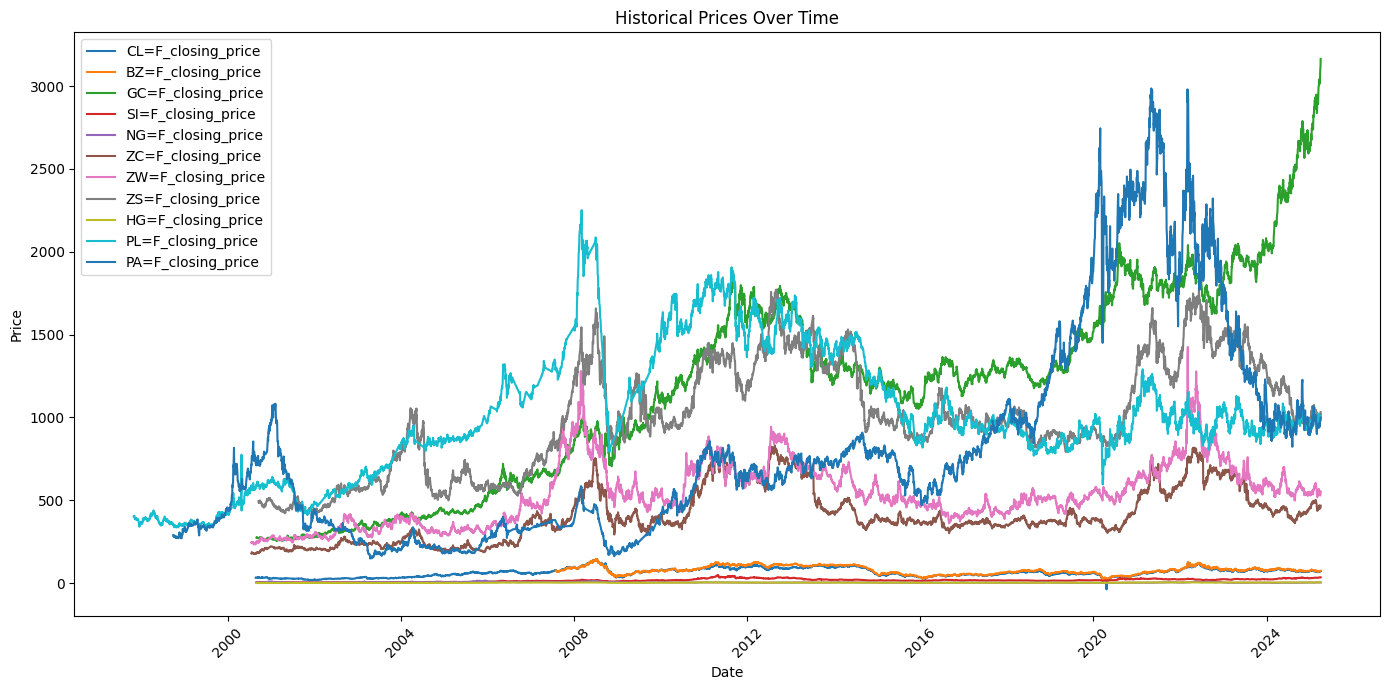

In [12]:
plt.figure(figsize=(14, 7))

for col in filled_df.columns:
    if col != 'Date':
        plt.plot(filled_df['Date'], filled_df[col], label=col)

# Set plot title and labels
plt.title("Historical Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


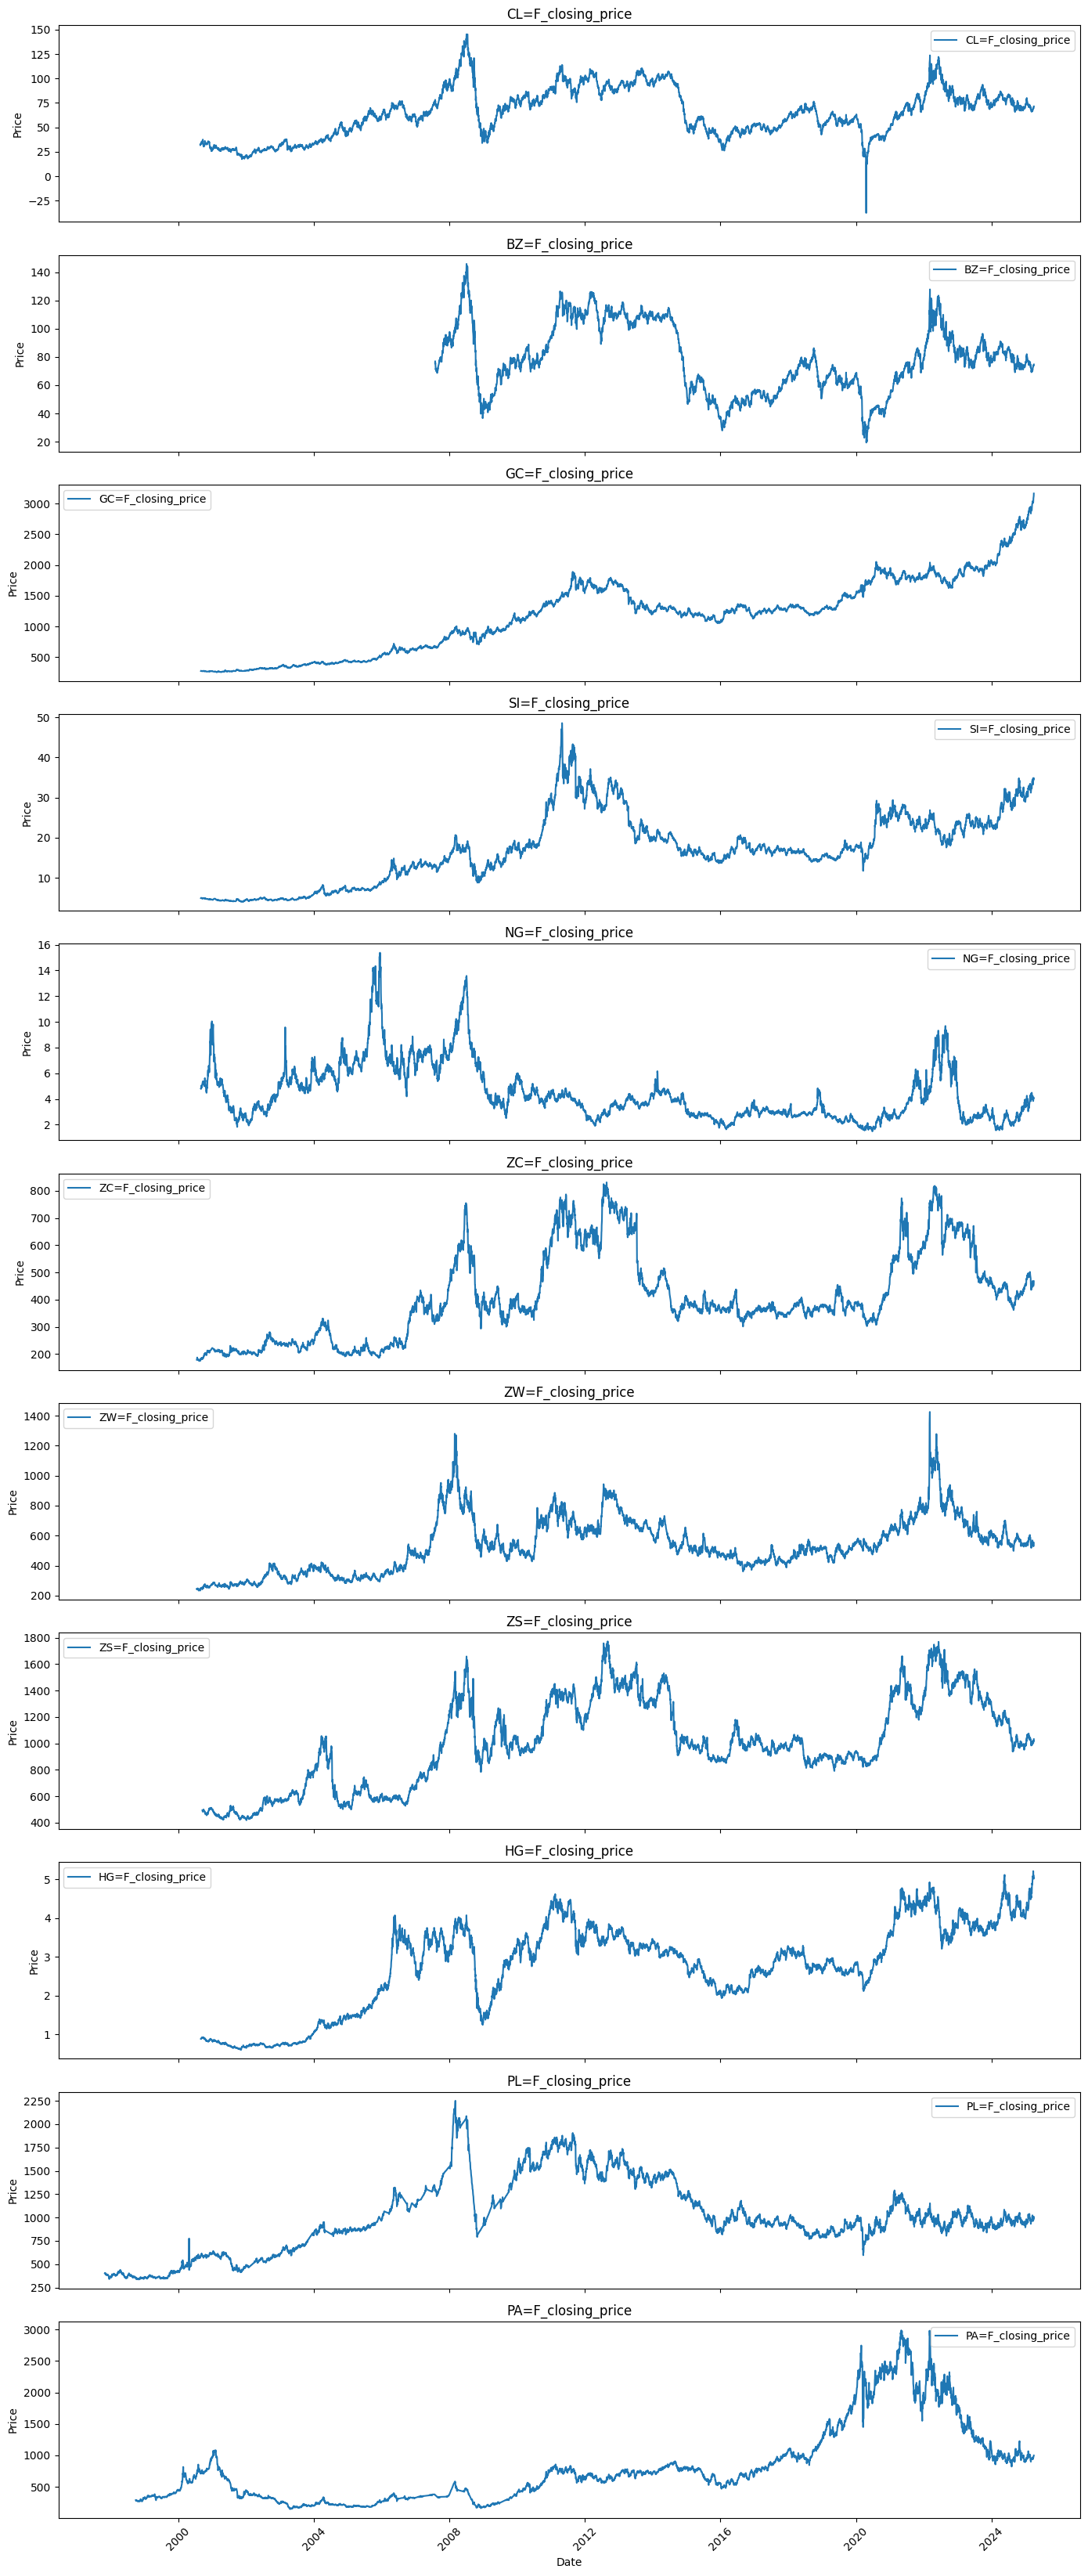

In [14]:
commodity_columns = [col for col in filled_df.columns if col != 'Date']
num_plots = len(commodity_columns)
fig, axs = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), sharex=True)
if num_plots == 1:
    axs = [axs]

for ax, col in zip(axs, commodity_columns):
    ax.plot(filled_df['Date'], filled_df[col], label=col)
    ax.set_title(col)
    ax.set_ylabel("Price")
    ax.legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Correlation Matrix

This section computes and displays a correlation matrix for all commodity price columns. The correlation matrix helps identify the strength and direction of relationships between different assets, making it easier to understand how they move together.

New Column Names: ['Date', 'Crude Oil Price', 'Brent Crude Price', 'Gold Price', 'Silver Price', 'Natural Gas Price', 'Corn Price', 'Wheat Price', 'Soybean Price', 'Copper Price', 'Platinum Price', 'Palladium Price']


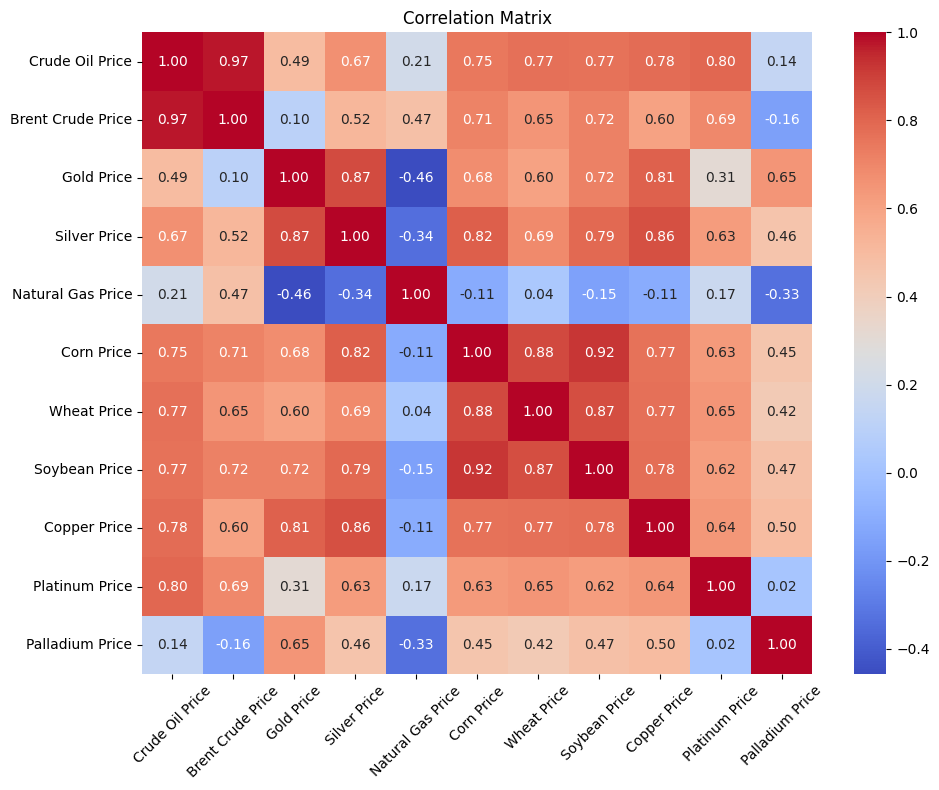

In [16]:
rename_dict = {
    'CL=F_closing_price': 'Crude Oil Price',
    'BZ=F_closing_price': 'Brent Crude Price',
    'GC=F_closing_price': 'Gold Price',
    'SI=F_closing_price': 'Silver Price',
    'NG=F_closing_price': 'Natural Gas Price',
    'ZC=F_closing_price': 'Corn Price',
    'ZW=F_closing_price': 'Wheat Price',
    'ZS=F_closing_price': 'Soybean Price',
    'HG=F_closing_price': 'Copper Price',
    'PL=F_closing_price': 'Platinum Price',
    'PA=F_closing_price': 'Palladium Price'
}

renamed_df = filled_df.copy()
renamed_df = renamed_df.rename(columns=rename_dict)
print("New Column Names:", renamed_df.columns.tolist())
numeric_df = renamed_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. 30-Day Volatility Analysis

This section calculates the 30-day rolling volatility for each commodity by computing the standard deviation of daily percentage returns over a 30-day window. This analysis provides insight into periods of increased market uncertainty or stability for each asset.


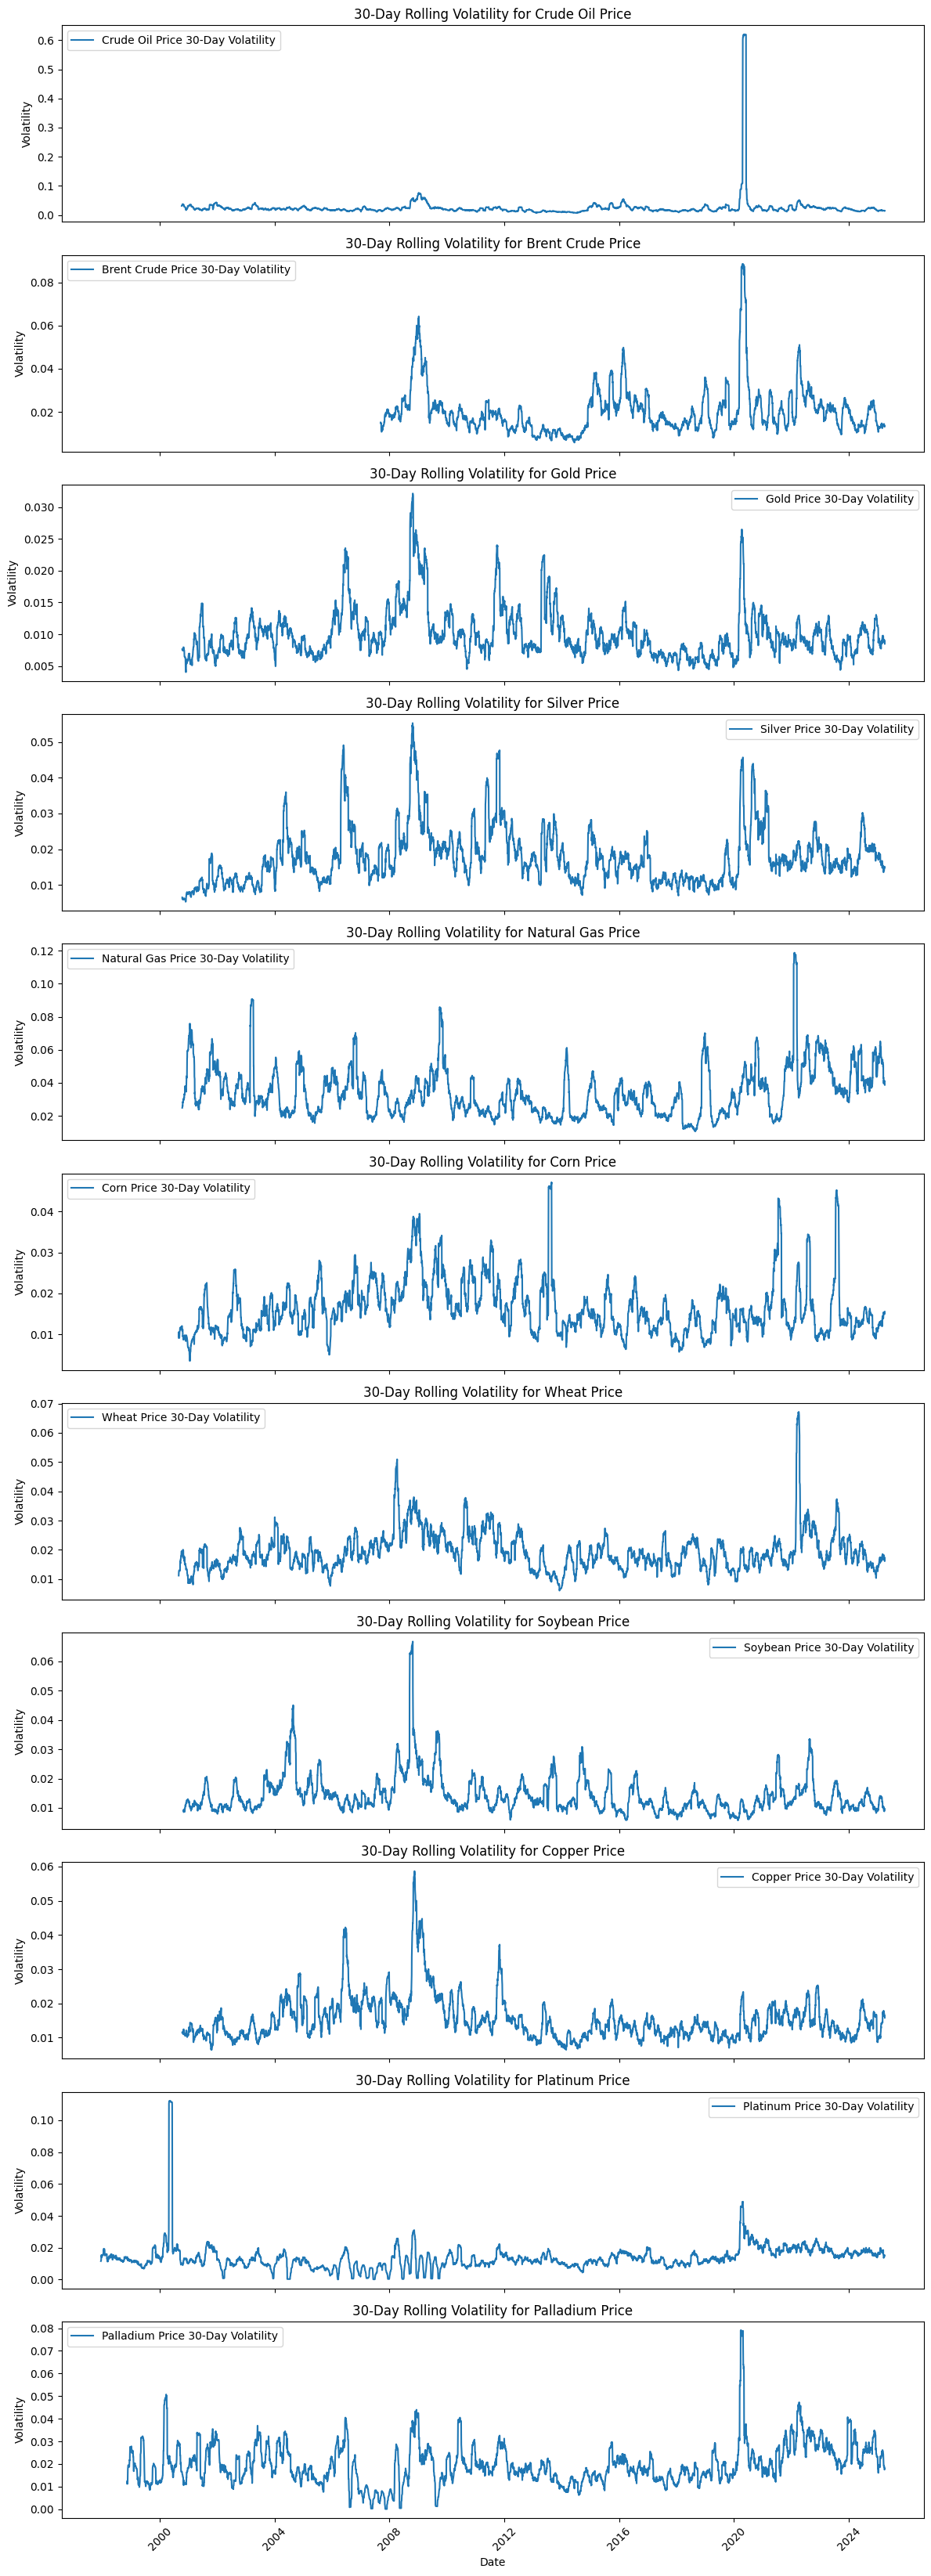

In [18]:
df_vol = renamed_df.copy()
df_vol = df_vol.sort_values("Date")
df_vol.set_index("Date", inplace=True)

returns = df_vol.pct_change()
window = 30  # 30-day rolling window
rolling_volatility = returns.rolling(window=window).std()
commodity_columns = rolling_volatility.columns
num_commodities = len(commodity_columns)

fig, axs = plt.subplots(num_commodities, 1, figsize=(12, 3 * num_commodities), sharex=True)

if num_commodities == 1:
    axs = [axs]

for ax, col in zip(axs, commodity_columns):
    ax.plot(rolling_volatility.index, rolling_volatility[col], label=f"{col} 30-Day Volatility")
    ax.set_title(f"30-Day Rolling Volatility for {col}")
    ax.set_ylabel("Volatility")
    ax.legend()
    
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()